In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## ***<span style="color: orange;">Construire un Nano-LLM pour le Résumé de Texte</span>***

---

**Ce noteook contient les principales étapes pour entrainer un LLM(`GPT-2`) pour le résumé de text**
1. <span style="color: cyan;">Nettoyage de données :</span> Simplifier le texte pour faciliter l'apprentissage
2. <span style="color: cyan;">Pré-entraînement :</span> Apprendre au modèle la structure de la langue anglaise sur un corpus brut
3. <span style="color: cyan;">Fine-tuning :</span> Spécialiser le modèle pour qu'il sache résumer du texte
4. <span style="color: cyan;">Évaluation & Inférence :</span> Tester les performances avec la métrique ***<span style="color: red;">ROUGE</span>***
----

#### <u><span style="color:#1E90FF">***1. Installation et Importation des Outils***</span></u>

Les importations nécessaires sont énumérées ci-dessous:
- `pytorch`: Pour construire et entraîner le réseau de neurones
- `SpaCy`: Pour le traitemnt linguistique(nettoyage, lemmatisation...)
- `torchMetrics`: Pour calculer le score <span style="color: red;">ROUGE</span>(évaluation standard en résumé automatique)

In [ ]:
# !pip install nltk spacy torch numpy pandas tqdm torchmetrics pip  nltk
# !python -m spacy download en_core_web_sm

In [6]:
import spacy
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torchmetrics.text import ROUGEScore

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


#### <u><span style="color:#1E90FF">***2. Installation et Importation des Outils***</span></u>

Pour cette tâche, deux fichiers de données sont nécessaires pour la phase d'entraînement.

1. <span style="color:#32CD32;"><strong>Corpus Brut</strong></span> : Une grande quantité de données textuelles non traité venant du web pour apprendre la structure générale de la langue (grammaire, syntaxe).

2. <span style="color:#32CD32;"><strong>Dataset de Résumé</strong></span> : Des paires `Texte -> Résumé` pour apprendre la tâche spécifique.


In [ ]:
# importation du corpus
with open("/content/drive/MyDrive/Colab Notebooks/LLM_atelier/data/raw_corpus.txt", "r") as f:
    raw_text = f.read()

# importation du df de résumées de textes
df_summary = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LLM_atelier/data/summaries.csv")

In [9]:
"""
diviser l'ensemble de données de résumés de textes
en un ensemble d'apprentissage et un ensemble de test
"""
df_train = df_summary.iloc[:-5]
df_test = df_summary.iloc[-5:]

#### <u><span style="color:#1E90FF">***3. Nettoyage du données***</span></u>

- <span style="color:#32CD32"><strong>Nettoyage</strong></span> : On retire le HTML et les URLs qui n'apportent pas de sens linguistique

- <span style="color:#32CD32"><strong>Lemmatisation</strong></span> : On utilise SpaCy pour transformer les mots en leur racine(**Lemmes**) (example `chattons -> chat`). Cela réduit la taille du vocabulaire nécessaire, rendant l'entraînement plus rapide sur des ressources machine limités


In [10]:
# chargement du modèle NLP du spacy
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    """
    pipeline de nettoyage :
    1. suppression HTML & URLs
    2. minuscules & suppression caractères spéciaux (sauf points)
    3. lemmatisation (run -> running) via SpaCy
    """
    text = re.sub(r'<[^>]+>', ' ', str(text)) # retire les aHTML
    text = re.sub(r'http\S+', ' ', text)      # retire URLs
    text = re.sub(r"[^a-zA-Z0-9\s\.]", "", text.lower()) # normalizer les alphanumériques

    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_space]

# récupérez des tokens a partir de corpus.
tokens_raw = clean_text(raw_text)

print(tokens_raw)

['welcome', 'this', 'be', 'an', 'example', '....', 'text', 'with', 'too', 'many', 'space', '.', 'here', 'a', 'sample', 'cat', 'be', 'amazing', 'animal', 'this', 'be', 'another', 'sentence', 'but', 'its', 'repeat', '.', 'this', 'be', 'another', 'sentence', 'but', 'its', 'repeat', '.', 'random', 'tweet', 'lol', 'soooo', 'cool', 'bonjour', 'le', 'monde', 'some', 'html', 'check', 'this', 'out', 'I', 'loooove', 'nlp', 'nlp', 'nlp', 'welcome', 'this', 'be', 'an', 'example', '....', 'text', 'with', 'too', 'many', 'space', '.', 'here', 'a', 'sample', 'cat', 'be', 'amazing', 'animal', 'this', 'be', 'another', 'sentence', 'but', 'its', 'repeat', '.', 'this', 'be', 'another', 'sentence', 'but', 'its', 'repeat', '.', 'random', 'tweet', 'lol', 'soooo', 'cool', 'bonjour', 'le', 'monde', 'some', 'html', 'check', 'this', 'out', 'I', 'loooove', 'nlp', 'nlp', 'nlp', 'welcome', 'this', 'be', 'an', 'example', '....', 'text', 'with', 'too', 'many', 'space', '.', 'here', 'a', 'sample', 'cat', 'be', 'amazing

#### <u><span style="color:#1E90FF">***4. Construction du Vocabulaire Unifié***</span></u>

le vocabulaire unifié contient des données provenant de la collection de données qui forme le corpus (`raw_text`) et le dataset de résumé de texte(`df_summary`)

In [11]:
tokens_csv = []

for _, row in df_train.iterrows():
    tokens_csv.extend(clean_text(row['text']))
    tokens_csv.extend(clean_text(row['summary']))

all_tokens = tokens_raw + tokens_csv
vocab_counts = Counter(all_tokens)
vocab_size = 1500 # Limit size

# Ajout des Tokens Spéciaux :
# <UNK>: Mot inconnu
# <SEP>: Séparateur (Indique au modèle : "Le texte est fini, commence le résumé")
# <EOS>: Fin de séquence (Indique : "J'ai fini de parler")
itos = ["<PAD>", "<UNK>", "<SEP>", "<EOS>"] + [w for w, _ in vocab_counts.most_common(vocab_size - 4)]
stoi = {w: i for i, w in enumerate(itos)}

def encode(token_list):
    return [stoi.get(t, stoi["<UNK>"]) for t in token_list]

def decode(ids):
    return " ".join([itos[i] for i in ids])

print(f"taille du vocab globale : {len(itos)}")

taille du vocab globale : 89


#### <u><span style="color:#1E90FF">***5. Création des Tensors d'Entraînement***</span></u>

Nous transformons nos textes en suites de nombres (tenseurs) que PyTorch peut comprendre.

- <span style="color:#32CD32">**Tenseur Pré-entraînement** :</span> Une longue suite ininterrompue de mots issus du web.

- <span style="color:#32CD32">**Tenseur Fine-tuning** :</span> Une suite structurée sous la forme : Article `<SEP>` Résumé `<EOS>`. C'est ainsi que nous enseignerons la tâche de résumé.



In [12]:
# tensor A : pré entraînement
raw_ids = encode(tokens_raw)
tensor_pretrain = torch.tensor(raw_ids, dtype=torch.long).to(device)

# tensor B : fine tune
# format : texte <SEP> résumé <EOS>
ft_ids = []
for _, row in df_train.iterrows():
    ft_ids.extend(encode(clean_text(row['text'])))
    ft_ids.append(stoi["<SEP>"])
    ft_ids.extend(encode(clean_text(row['summary'])))
    ft_ids.append(stoi["<EOS>"])

tensor_finetune = torch.tensor(ft_ids, dtype=torch.long).to(device)

print(f"forme du tensor de pré-entraînement : {tensor_pretrain.shape}")
print(f"forme du tensor de fine tune : {tensor_finetune.shape}")


forme du tensor de pré-entraînement : torch.Size([318])
forme du tensor de fine tune : torch.Size([651])


#### <u><span style="color:#1E90FF">***6. Architecture du Modèle***</span></u>

- <span style="color:#32CD32"><strong>Embeddings</strong></span> : Convertit les entiers (mots) en vecteurs riches en sens.

- <span style="color:#32CD32"><strong>Positional Embedding</strong></span> : Ajoute la notion d'ordre (le modèle lit tout en même temps, il a besoin de savoir que le mot A est avant le mot B).

- <span style="color:#32CD32"><strong>Self-Attention (Masquée)</strong></span> : Permet au modèle de comprendre le contexte ("bank" = rivière ou argent ?). Le masquage est crucial : il empêche le modèle de "tricher" en regardant les mots futurs qu'il doit prédire.

- <span style="color:#32CD32"><strong>FeedForward</strong></span> : La couche de réflexion qui traite l'information extraite par l'attention.


In [15]:
class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size):
        super().__init__()
        # projections linéaires pour key, query & value
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        #  un masque (tril) : empêche le modele d'accédé les tokens du futur
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        # k = ce que j’ai (keys)
        k = self.key(x)

        # q = ce que je cherche (query)
        q = self.query(x)

        # calcul de l’attention + scaling
        wei = q @ k.transpose(-2, -1) * C**-0.5

        #  masque pour cacher le futur
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        # normalisation softmax = poids d’attention
        wei = F.softmax(wei, dim=-1)

        # v = values
        v = self.value(x)

        # return somme pondérée des valeurs
        return wei @ v


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size):
        super().__init__()

        # plusieurs HEADs mises en parallèle
        self.heads = nn.ModuleList([
            Head(head_size, n_embd, block_size) for _ in range(num_heads)
        ])

        # projection finale pour réassembler les HEADs
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        #concaténation des sorties des têtes d’attention
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.proj(out)


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()

        # MLP appliqué après l'attention : expande → ReLU → réduit
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


class NanoLLM(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()

        # token embedding + positionnal embedding
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)

        # empilement de couches Transformer
        self.blocks = nn.Sequential(*[
            nn.ModuleDict(dict(
                sa = MultiHeadAttention(n_head, n_embd // n_head, n_embd, block_size),
                ffwd = FeedForward(n_embd),
                ln1 = nn.LayerNorm(n_embd),
                ln2 = nn.LayerNorm(n_embd)
            ))
            for _ in range(n_layer)
        ])

        # tete finale : distribution sur le vocabulaire
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # positionnal embedding
        pos = torch.arange(T, device=idx.device)
        x = self.token_embedding(idx) + self.position_embedding(pos)

        # passage dans les blocs Transformer
        for block in self.blocks:
            x = x + block.sa(block.ln1(x))   # attention + skip connection
            x = x + block.ffwd(block.ln2(x)) # feedforward + skip

        # logits du modèle
        logits = self.lm_head(x)

        # calcul de la loss
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

#### <u><span style="color:#1E90FF">***7. Entraînement Phase 1 (Pre-training)***</span></u>

***<span style="color:#32CD32">Objectif :*** </span> Assimiler les régularités linguistiques — par exemple, une occurrence de "le" est souvent suivie d’un nom. L’exposition au corpus brut permet au modèle d’ancrer ces structures fondamentales.

In [16]:
# les hyperparameters
block_size = 32
batch_size = 32
n_embd = 64
n_head = 4
n_layer = 4
lr = 1e-3

def get_batch(data_source):
    ix = torch.randint(len(data_source) - block_size, (batch_size,))
    x = torch.stack([data_source[i:i+block_size] for i in ix])
    y = torch.stack([data_source[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

model = NanoLLM(len(itos), n_embd, block_size, n_head, n_layer).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_history = []

print("\n Pre-entraienemtn avec le corpus(vocabulaire)")
for i in range(500):
    xb, yb = get_batch(tensor_pretrain)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Epoch N°{i}: Loss {loss.item():.4f}")
        loss_history.append(loss.item())


 Pre-entraienemtn avec le corpus(vocabulaire)
Epoch N°0: Loss 4.9266
Epoch N°100: Loss 0.0338
Epoch N°200: Loss 0.0222
Epoch N°300: Loss 0.0120
Epoch N°400: Loss 0.0142


#### <u><span style="color:#1E90FF">***8. Entraînement Phase 2 (Fine-tuning)***</span></u>

- ***<span style="color:#32CD32">Objectif :***</span> Approfondir le comportement de résumé en réutilisant le même modèle, cette fois exposé à des données structurées. Le token `<SEP>` agit alors comme déclencheur signalant le début de la condensation textuelle.

- ***<span style="color:#32CD32">Astuce :***</span> Un abaissement du learning rate permet de préserver les schémas linguistiques acquis lors de la phase précédente et d’éviter une altération brutale des représentations internes.



 Fine-tune avec (tâche de résumé de texte)
Step 0: Loss 11.3635
Step 100: Loss 0.1463
Step 200: Loss 0.0525
Step 300: Loss 0.0316
Step 400: Loss 0.0302


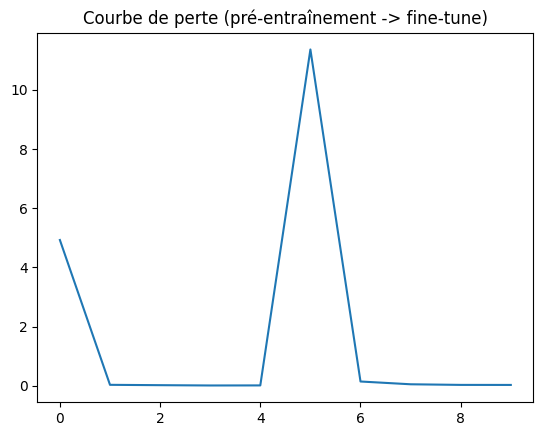

In [17]:
# réduire le taux d'apprentissage pour le fine-tune
for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-4

print("\n Fine-tune avec (tâche de résumé de texte)")
for i in range(500):
    xb, yb = get_batch(tensor_finetune)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}: Loss {loss.item():.4f}")
        loss_history.append(loss.item())

plt.plot(loss_history)
plt.title("Courbe de perte (pré-entraînement -> fine-tune)")
plt.show()

#### <u><u><span style="color:#1E90FF">***9. Évaluation du Modèle***</span></u>

- ***<span style="color:#32CD32">Objectif :***</span> Phase de test : ROUGE (Recall-Oriented Understudy for Gisting Evaluation) sert d’indicateur principal pour mesurer la qualité du résumé.

- ***<span style="color:#32CD32">ROUGE-1 :***</span> Mesure l’alignement entre prédiction et référence via les unités lexicales partagées.

- ***<span style="color:#32CD32">ROUGE-2 :***</span> Mesure la cohérence via les bigrammes partagés entre prédiction et référence.


In [18]:
def generer_resume(model, article_text):
    model.eval()

    # préparation de l’entrée : Article + <SEP>
    tokens = clean_text(article_text)
    ids = [stoi.get(t, stoi["<UNK>"]) for t in tokens]
    ids.append(stoi["<SEP>"])

    # si le texte serait vide après nettoyage
    if len(ids) == 0:
        ids = [stoi["<SEP>"]]

    context = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

    # g"nération du résumé
    generated_ids = []
    for _ in range(20):  # on génère maximum 20 tokens
        logits, _ = model(context[:, -block_size:])
        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)

        # si <EOS> → fin de génération
        if next_idx.item() == stoi["<EOS>"]:
            break

        context = torch.cat((context, next_idx), dim=1)
        generated_ids.append(next_idx.item())

    # conversion des IDs vers texte
    return " ".join([itos[i] for i in generated_ids])

In [19]:
rouge = ROUGEScore()

# --- Évaluation ROUGE ---
print("\n--- Évaluation ROUGE avec TorchMetrics ---")

# Jeu de test : les 5 dernières lignes mises de côté
df_test = df_summary.iloc[-5:]

preds = []
targets = []

for _, row in df_test.iterrows():
    article = row['text']
    reference_summary = row['summary']

    generated_summary = generer_resume(model, article)

    preds.append(generated_summary)
    targets.append(reference_summary)

    print(f"Référence : {reference_summary}")
    print(f"Généré    : {generated_summary}\n")

# Calcul des scores ROUGE
scores = rouge(preds, targets)

print("Scores finaux :")
print(f"ROUGE-1 (Unigrammes) : {scores['rouge1_fmeasure'].item():.4f}")
print(f"ROUGE-2 (Bigrammes)  : {scores['rouge2_fmeasure'].item():.4f}")
print(f"ROUGE-L (Longest)    : {scores['rougeL_fmeasure'].item():.4f}")


ModuleNotFoundError: Stemmer and/or `rougeLsum` requires that `nltk` is installed. Use `pip install nltk`.

#### <u><u><span style="color:#1E90FF">***9. Inférence***</span></u>

In [ ]:
def test_single_sentence(sentence):
    print(f"Phrase d'entrée : '{sentence}'")
    summary = generer_resume(model, sentence)
    print(f"Résumé généré   : {summary}")

test_sentence = "Neural networks are a set of algorithms modeled after the human brain."
test_single_sentence(test_sentence)